# Boosting and Stacking

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

We'll once again use the human activity dataset, built with inertial sensor embedded smartphones.

In [3]:
df = pd.read_csv("./data/Human_Activity_Recognition_Using_Smartphones_Data.csv")
df.info()
# 562 features, 10299 datapoints

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 44.2+ MB


In [6]:
float_columns = (df.dtypes == float)
print( (df.loc[:,float_columns].max()==1.0).all() )
print( (df.loc[:,float_columns].min()==-1.0).all() )
# All features are between -1.0 and 1.0, though scaling is not required for tree-based methods

True
True


Then we can encode the category columnns to integers, in this case this is only the "Activity" column

In [ ]:
df.loc[:, df.dtypes == object].columns

Index(['Activity'], dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df.loc[:, "Activity"] = le.fit_transform(df["Activity"])

0        2
1        2
2        2
3        2
4        2
        ..
10294    5
10295    5
10296    5
10297    5
10298    5
Name: Activity, Length: 10299, dtype: int64

Then split up the train and test data

In [34]:
from sklearn.model_selection import train_test_split

target = "Activity"
features = df.drop(columns=[target]).columns

X = df[features]
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.3, 
    random_state=42
    )

And finally start fitting a basic model with different amounts of n_estimators. We'll evaluate the performance and plot fitting quality

Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 200 trees
Fitting model with 400 trees


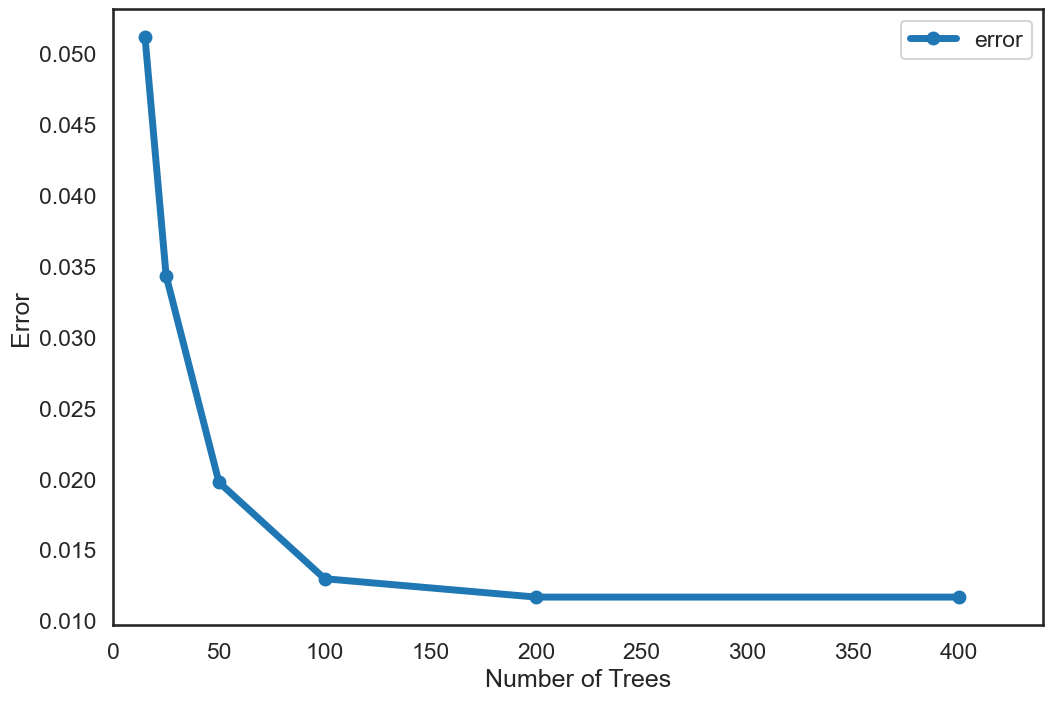

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train, y_train)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

In [36]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

GV_GBC.best_estimator_

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,400
,subsample,0.5
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.96      0.97      0.97       559
           2       0.97      0.97      0.97       549
           3       1.00      1.00      1.00       539
           4       0.99      1.00      0.99       419
           5       0.99      0.99      0.99       427

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



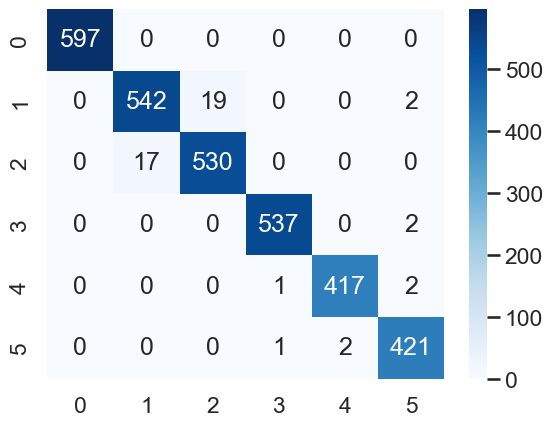

In [38]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

## Adaboost and Gridsearch

In [51]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

GV_ABC.best_estimator_

,estimator,DecisionTreeC...r(max_depth=1)
,n_estimators,100
,learning_rate,0.01
,algorithm,'deprecated'
,random_state,None
,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [52]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.00      0.00      0.00         0
           2       1.00      0.49      0.66      1109
           3       1.00      0.39      0.56      1384
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.54      3090
   macro avg       0.50      0.31      0.37      3090
weighted avg       1.00      0.54      0.68      3090



p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

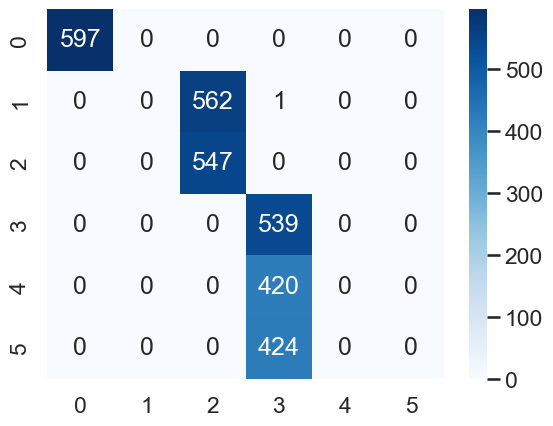

In [41]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

## Voting classifier with Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression

# L2 regularized logistic regression
LR_L2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga').fit(X_train, y_train)
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       0.95      0.96      0.95       558
           2       0.95      0.95      0.95       547
           3       1.00      0.99      0.99       544
           4       0.98      1.00      0.99       413
           5       1.00      0.98      0.99       430

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



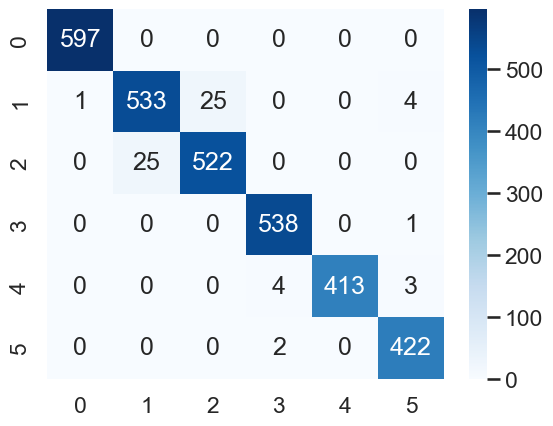

In [49]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       597\n           1       0.97      0.96      0.97       563\n           2       0.97      0.97      0.97       547\n           3       1.00      1.00      1.00       539\n           4       1.00      1.00      1.00       420\n           5       0.99      1.00      0.99       424\n\n    accuracy                           0.99      3090\n   macro avg       0.99      0.99      0.99      3090\nweighted avg       0.99      0.99      0.99      3090\n'

In [50]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.97      0.96      0.97       563
           2       0.97      0.97      0.97       547
           3       1.00      1.00      1.00       539
           4       1.00      1.00      1.00       420
           5       0.99      1.00      0.99       424

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



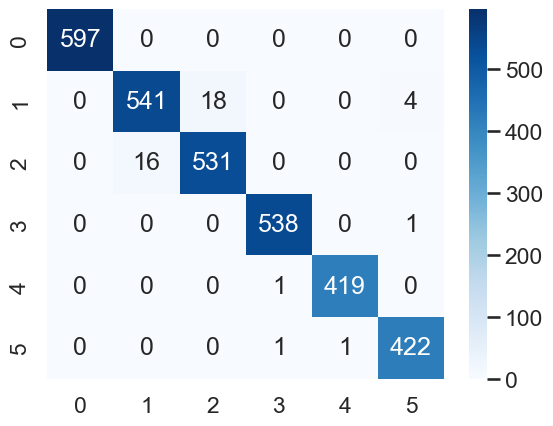

In [45]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()